## Simulation-based Inference Tutorial

**Description:** In this tutorial, we will go over a demonstration of using `slsim`-simulated strong lens images to perform simulation-based inference (SBI), specifically neural posterior estimation (NPE), with the `sbi` package.

**Author:** Steven Dillmann

**Date:** 9 Aug 2025

### 0. Setup

In [ ]:
# === Installation ===

%pip install sbi
%pip install tarp
%pip install deprecation
%pip install corner
%pip install matplotlib
%pip install pandas
%pip install h5py

In [12]:
# === Imports ===

# Basic
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import corner
import pickle
import os 

# Torch
import torch
from torch.distributions import Normal

# SBI
from sbi.inference import NPE
from sbi.neural_nets import posterior_nn
from sbi.neural_nets.embedding_nets import CNNEmbedding
from sbi.utils import MultipleIndependent
from tarp import get_tarp_coverage

### 1. Data Loading

In [13]:
# === Data Loading ===

# TODO: Change this to the path to the data folder on your machine
data_folder_path = "/Users/steven/Desktop/slsim/sbi_data/"

# Functions to load image data and labels/targets
def load_image_data(file_path: str) -> torch.Tensor:
    with h5py.File(file_path, 'r') as f:
        data = f["data"][:] 
    data_tensor = torch.tensor(data, dtype=torch.float32)
    return data_tensor

def load_parameter_labels(file_path: str, keep_columns: list) -> torch.Tensor:
    parameters = pd.read_csv(file_path)
    parameters = parameters[keep_columns]
    parameters_tensor = torch.tensor(parameters.values, dtype=torch.float32)
    return parameters_tensor

# Load the training and test image data
train_data_path = os.path.join(data_folder_path, "train", "image_data.h5")
test_data_path = os.path.join(data_folder_path, "test", "image_data.h5")
train_data = load_image_data(train_data_path)
test_data = load_image_data(test_data_path)
print("Training Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)


# Load the training and test labels/targets and select the parameters you want to infer
parameters_to_infer = [
    "main_deflector_parameters_theta_E", # Einstein radius
    "main_deflector_parameters_gamma1", # gamma1
    "main_deflector_parameters_gamma2", # gamma2
    "main_deflector_parameters_gamma", # gamma_lens
    "main_deflector_parameters_e1", # e1
    "main_deflector_parameters_e2", # e2
    "main_deflector_parameters_center_x", # x_lens
    "main_deflector_parameters_center_y", # y_lens
    "source_parameters_center_x", # x_source
    "source_parameters_center_y" # y_source
    ]
parameter_names = [r'$\theta_\mathrm{E}$',r'$\gamma_1$',r'$\gamma_2$',r'$\gamma_\mathrm{lens}$',r'$e_1$',
               r'$e_2$',r'$x_\mathrm{lens}$',r'$y_\mathrm{lens}$',r'$x_\mathrm{src}$',r'$y_\mathrm{src}$']

train_labels_path = os.path.join(data_folder_path, "train", "metadata.csv")
test_targets_path = os.path.join(data_folder_path, "test", "metadata.csv")
train_theta = load_parameter_labels(train_labels_path, parameters_to_infer)
test_theta = load_parameter_labels(test_targets_path, parameters_to_infer)
print("Training Labels Shape:", train_theta.shape)
print("Test Targets Shape:", test_theta.shape)

Training Data Shape: torch.Size([5000, 180, 180])
Test Data Shape: torch.Size([1000, 180, 180])
Training Labels Shape: torch.Size([5000, 10])
Test Targets Shape: torch.Size([1000, 10])


### 2. Neural Network Architecture

In [14]:
# === Define Neural Network ===

# Define embedding network
embedding_net = CNNEmbedding(
    input_shape=(180, 180),                 # Input shape of the images
    in_channels=1,                          # Number of channels in the input images
    out_channels_per_layer=[16, 32, 64],    # Number of channels in each layer
    num_conv_layers=3,                      # Number of convolutional layers
    num_linear_layers=2,                    # Number of linear layers
    output_dim=32,                          # Output dimension of the embedding network
    kernel_size=3,                          # Kernel size of the convolutional layers
    pool_kernel_size=2                      # Kernel size of the pooling layers
)

# Define density estimator
density_estimator= posterior_nn(
    model='maf',                           # Model type: 'maf', 'nsf', 'mdn', etc.
    hidden_features=32,                    # Number of hidden features in the MAF
    num_transforms=10,                     # Number of transformations in the MAF
    embedding_net=embedding_net            # Embedding network
)

# Define the NPE inference object
npe = NPE(density_estimator=density_estimator)

### 3. Training

In [16]:
# === Training ===

# Pass simulated data to NPE inference object
inference = npe.append_simulations(train_theta, train_data)

# Train the posterior estimator
posterior_estimator = inference.train(
    training_batch_size=128,                # Batch size for training
    learning_rate=0.0005,                   # Learning rate for training
    validation_fraction=0.1,                # Fraction of data to use for validation
    stop_after_epochs=5,                    # Stop training after this many epochs if the validation loss does not improve
    max_num_epochs=50                       # Maximum number of epochs for training 
) 

 Neural network successfully converged after 11 epochs.

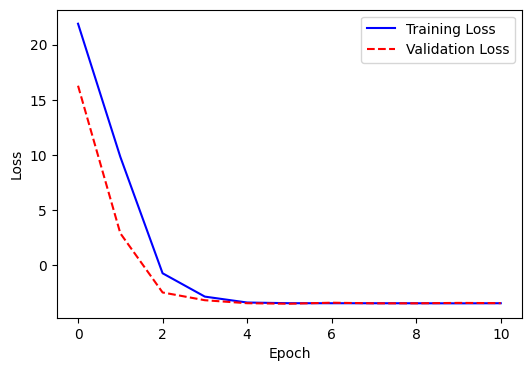

In [22]:
# === Training Visualization===

# Plot loss curve
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(inference.summary['training_loss'], label='Training Loss', color='blue', linestyle='-')
ax.plot(inference.summary['validation_loss'], label='Validation Loss', color='red', linestyle='--')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

### 4. Inference

In [18]:
# === Inference ===

# Build the posterior
posterior = inference.build_posterior(posterior_estimator)

# Perform inference on test set
n_samples = 500 # Number of samples to draw from the posterior
samples_theta = posterior.sample_batched((n_samples,), x = test_data)

Drawing 500 posterior samples: 100%|██████████| 500/500 [00:08<00:00, 58.13it/s]


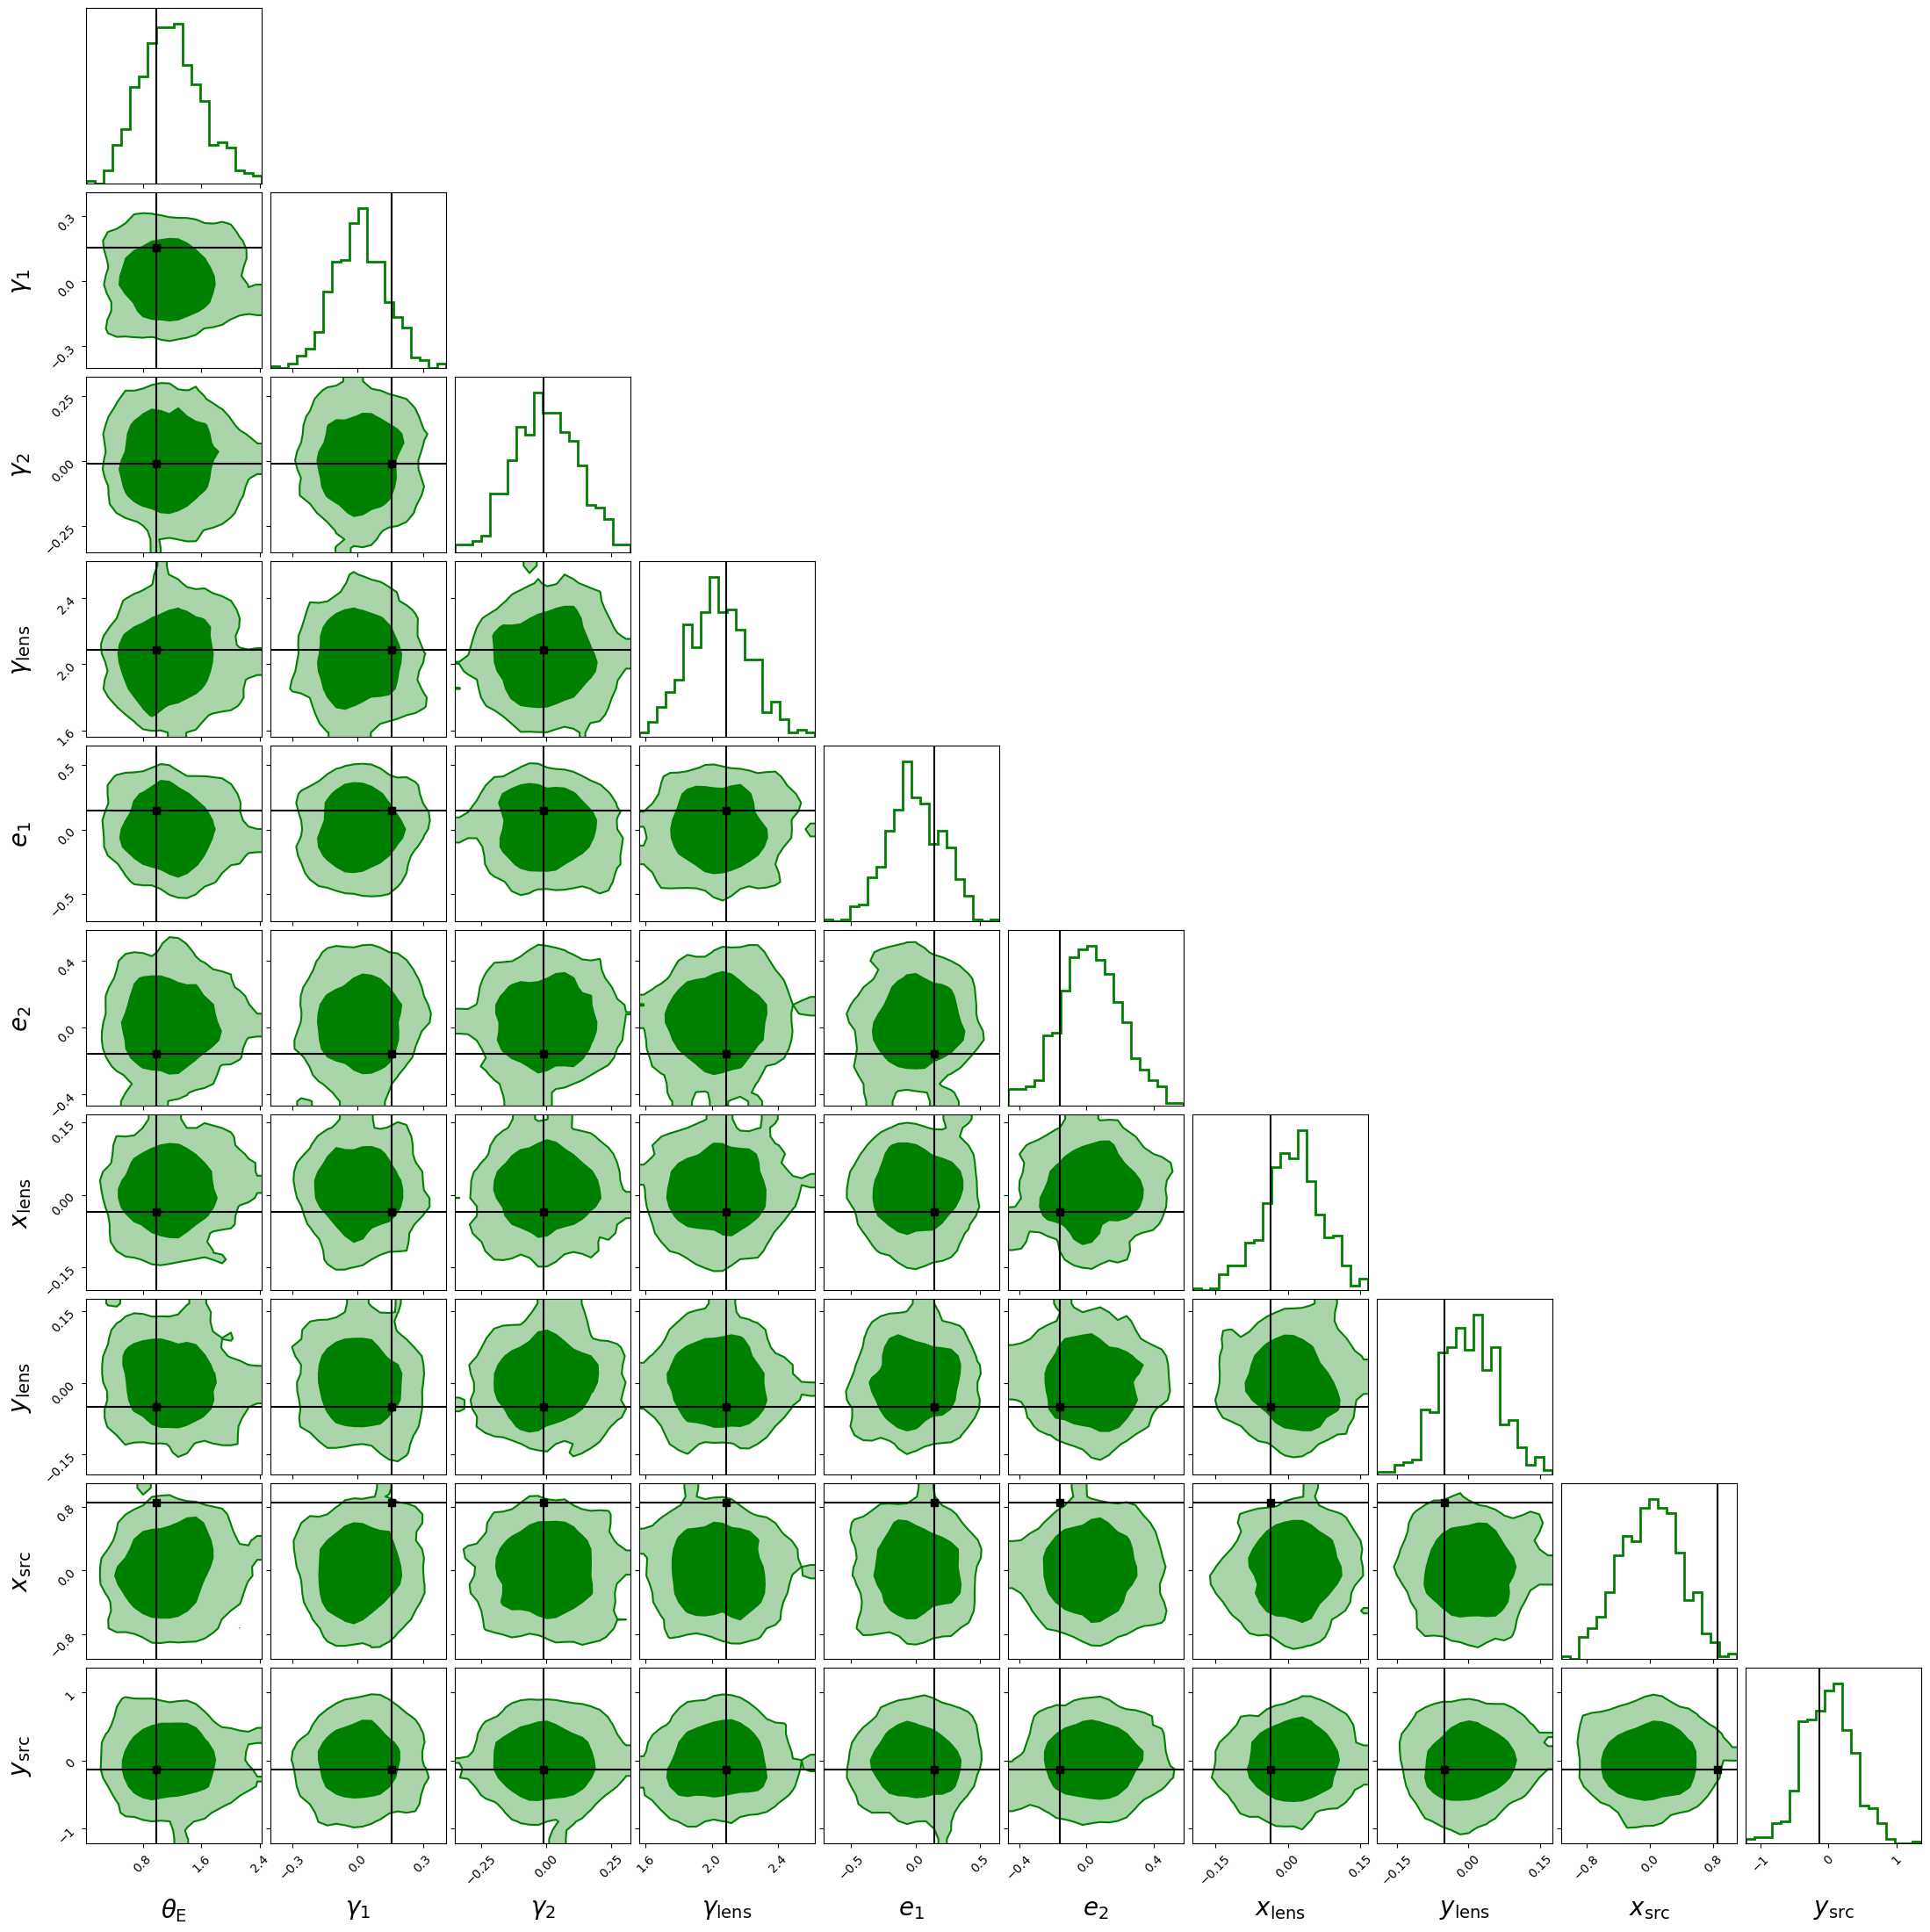

In [19]:
# Visualize the posterior
test_example_index = 7 # TODO: Change this to the index of the test example you want to visualize
test_example_data = test_data[test_example_index]
test_example_theta = test_theta[test_example_index]
test_example_samples = samples_theta[:, test_example_index]

fig = corner.corner(
        np.array(test_example_samples),
        labels=parameter_names,
        truths=test_example_theta,
        truth_color='k',
        levels=[0.68, 0.95],
        bins=20,
        plot_datapoints=False,
        fill_contours=True,
        max_n_ticks=3,
        smooth=1.0,
        hist_kwargs=dict(density=True, color='green', linewidth=2, histtype='step'),
        color='green',
        title_fmt='.2f',
        title_kwargs=dict(fontsize=20),
        label_kwargs=dict(fontsize=20),
    )

### 5. Diagnostics

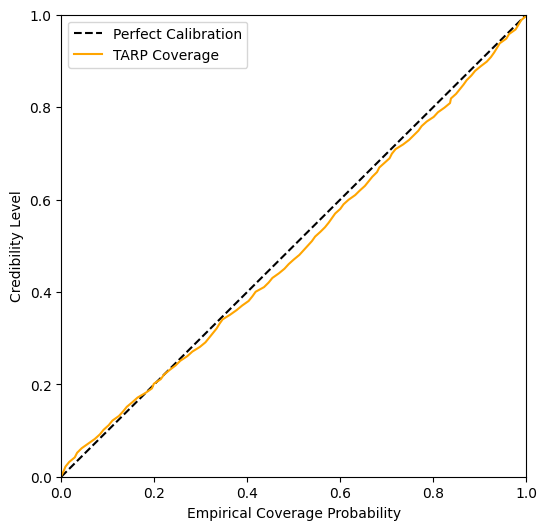

In [23]:
# === Calibration Testing ===

# Compute TARP coverage
ecp, alpha = get_tarp_coverage(
    np.array(samples_theta), 
    np.array(test_theta),
    seed = 42
)

# Plot coverage
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Perfect Calibration')
ax.plot(ecp, alpha, color='orange', label='TARP Coverage')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('Empirical Coverage Probability')
ax.set_ylabel('Credibility Level')
ax.legend()
plt.show()

In [25]:
# === Parity Testing === 

# # Choose parameter to generate parity plot for
# parameter_index = 9 # TODO: Change this to the index of the parameter you want to generate a parity plot for
# theta_true = np.array(test_theta)[:, parameter_index]
# theta_predicted = np.mean(np.array(samples_theta)[..., parameter_index], axis=0)
# theta_error = np.std(np.array(samples_theta)[..., parameter_index], axis=0)

# # Parity plot
# fig, ax = plt.subplots(figsize=(6, 6))
# ax.plot([np.min(theta_true), np.max(theta_true)], [np.min(theta_true), np.max(theta_true)], color='black', linestyle='--', label='Perfect Prediction')
# ax.errorbar(theta_predicted, theta_true, yerr=theta_error, fmt='.', color='purple', label='Predicted vs True')
# ax.set_xlabel('Predicted Value')
# ax.set_ylabel('True Value')
# ax.set_title('Parity Plot')
# ax.set_title(f'Parity Plot for {parameter_names[parameter_index]}')
# ax.legend()
# plt.show()